# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later.

In [98]:
from __future__ import unicode_literals, print_function, division
from collections import Counter
from io import open
import unicodedata
import string
import re
import random
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import numpy as np
from random import shuffle
import math

USE_CUDA = torch.cuda.is_available()

In [2]:
with open("/Users/carolineroper/Documents/School/Natural Language Processing/Char-NMT/data/train.txt", "r", encoding="utf8") as f:
    
    DE_seq = []
    EN_seq = []
    
    for i, line in enumerate(f):
        
        line = line.split('<JOIN>')
        DE_seq.append(line[0])
        EN_seq.append(line[1])

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.replace(" <EOS>", "")
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) #separates punctuation from the word
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) #strips anything that isn't a character of punctuation
    return s

In [4]:
def readLangs(seq1, seq2):
    print("Reading lines...")
    
    seq1 = [normalizeString(s) for s in seq1]
    seq2 = [normalizeString(s) for s in seq2]
    
    pairs = list(map(list, zip(seq1, seq2)))

    return pairs #, vocab1, vocab2

In [5]:
pairs = readLangs(DE_seq, EN_seq)

Reading lines...


### Filtering sentences

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed).

In [6]:
#will ultimately remove this and set MAX_LENGTH to either 50 like the paper or the longest sentence in corpus
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

In [7]:
def find_vocabulary(seq, vocab_size):
    counter = Counter()
    for sentence in seq:
        counter.update(sentence.split())
    vocabulary = [count[0] for count in counter.most_common(vocab_size)]
    return vocabulary

In [8]:
input_vocab = find_vocabulary([pair[0] for pair in pairs], 10000)
output_vocab = find_vocabulary([pair[1] for pair in pairs], 10000)

In [9]:
UNK_token = 0
SOS_token = 1
EOS_token = 2
PAD_token = 3

class Lang:
    def __init__(self, name, vocab):
        self.name = name
        self.vocab = vocab
        self.word2index = {}
        self.word2count = {}
        self.index2word = dict(zip(range(4,len(vocab)+4), vocab))
        self.index2word[UNK_token] = "<UNK>"
        self.index2word[SOS_token] = "<SOS>"
        self.index2word[EOS_token] = "<EOS>"
        self.index2word[PAD_token] = "<PAD>"
        self.word2index = {v: k for k, v in self.index2word.items()}
        self.n_words = len(self.index2word)

In [10]:
input_lang = Lang('ger', input_vocab)
output_lang = Lang('eng', output_vocab)

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [11]:
def indexesFromSentence(lang, sentence, seq_len):
    #returns 0 if not found in word2index
    indexes = [Counter(lang.word2index)[word] for word in sentence.split(' ')]
    #adds EOS token at EOS
    indexes.extend([EOS_token])
    #trims to the seq len
    indexes = indexes[0:(min(seq_len, len(indexes)))]
    #pads if needed
    indexes.extend([3] * (seq_len - len(indexes)))
    return indexes

def variableFromSentence(lang, sentence, seq_len):
    indexes = indexesFromSentence(lang, sentence, seq_len)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA:
        return result.cuda()
    else:
        return result

def variablesFromPair(pair, seq_len):
    input_variable = variableFromSentence(input_lang, pair[0], seq_len)
    target_variable = variableFromSentence(output_lang, pair[1], seq_len)
    return (input_variable, target_variable)

# Building the models

## The Encoder

<img src="images/encoder-network.png" style="float: right" />

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [12]:
BATCH_SIZE = 128

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size=BATCH_SIZE, dropout_p=0.2):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.embedding = nn.Embedding(input_size, hidden_size) #the input size is the number of words
        self.batch_size = batch_size
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout = dropout_p)
        self.dropout = nn.Dropout(self.dropout_p)
        
    def forward(self, x, hidden):
        seq_len = len(x)
        embedded = self.embedding(x).view(seq_len, self.batch_size, -1)
        output = self.dropout(embedded)
        for i in range(self.n_layers):
            output, hidden = self.lstm(output, hidden)
        return output, hidden

    def init_hidden(self):
        #the paper says to use "uniform initialization of parameters in [−0.1,0.1]: does that include these?"
        h0 = Variable(torch.zeros(1, 1, self.hidden_size)) #I think maybe one of the 1's should be the batch_size?
        c0 = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return h0.cuda(), c0.cuda()
        else:
            return h0, c0

### Luong Attention

In [14]:
class Attn(nn.Module):
    def __init__(self, hidden_size, method = 'dot', batch_size=BATCH_SIZE, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        attn_energies = Variable(torch.zeros(self.batch_size, seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[:,i] = self.score(hidden, encoder_outputs[i])
            

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        # I confirmed that this computes row-wise, which is what we need
        after_softmax = F.softmax(attn_energies)
        return after_softmax.unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = torch.diag(torch.matmul(hidden, torch.transpose(encoder_output,0,1)))
            #print ("energy", energy)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [89]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, batch_size = BATCH_SIZE):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, self.batch_size, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        
        #do I need to do this? the paper doesn't mention any type of rnn in the decoder
        #rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        #rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(word_embedded.squeeze(0), encoder_outputs)

        context = torch.bmm(attn_weights.transpose(0, 1), encoder_outputs.transpose(0, 1)) # B x 1 x N ####this throws an error now
        
        # Final output layer (next word prediction) using the hidden state and context vector
        word_embedded = word_embedded.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((word_embedded, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        # If I were using the GRU, I'd output hidden, not last_hidden
        return output, context, last_hidden, attn_weights

# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

In [90]:
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,\
          criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    # One SOS token for each stence, so length is batch size
    decoder_input = Variable(torch.LongTensor([[SOS_token]*batch_size]))
    decoder_context = Variable(torch.zeros(batch_size, decoder.hidden_size))
    decoder_hidden = encoder_hidden[0] # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()
        
    for di in range(target_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_variable[di])

        # Get most likely word index (highest value) from output
        topv, topi = decoder_output.data.topk(1)
        
        ni = topi.squeeze(1)

        decoder_input = Variable(ni) # Chosen word is next input
        if USE_CUDA: decoder_input = decoder_input.cuda()

        # Stop at end of sentence (not necessary when using known targets)
        # can't do this if we batchify
        # if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [91]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and a loss function (criterion).

In [92]:
hidden_size = 500
n_layers = 2

attn_model = Attn(hidden_size)
# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers=4, batch_size = BATCH_SIZE)
#(self, input_size, hidden_size, n_layers, batch_size=BATCH_SIZE, dropout_p=0.2):
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, batch_size=BATCH_SIZE) 

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Then set up variables for plotting and tracking progress:

In [93]:
# Configuring training
n_epochs = 5
plot_every = 5
print_every = 5

In [94]:
# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines above where the encoder and decoder are initialized (so they aren't reset) or simply run the notebook starting from the following cell.

In [95]:
SEQ_LENGTH = MAX_LENGTH

# Begin!
variables = [variablesFromPair(pair, seq_len=SEQ_LENGTH) for pair in pairs]
shuffle(variables)

In [99]:
for epoch in range(n_epochs):

    n_iters = math.floor(int(len(variables)/batch_size)) #put this in an outer loop for n_iter

    for n_iter in range(1, n_iters + 1):

        #print ("training pairs: ", training_pairs)
        #print ("training variables: ", training_pairs)
        start_ix = (n_iter - 1)*batch_size
        end_ix = n_iter*batch_size
        batch_vars = variables[start_ix:end_ix]
        inputs = [variable[0].data for variable in batch_vars]
        input_variable = Variable(torch.stack(inputs, 1).squeeze(), volatile=False)
        targets = [variable[1].data for variable in batch_vars]
        target_variable = Variable(torch.stack(targets, 1).squeeze(), volatile=False)

        criterion = nn.NLLLoss()

        # Run the train function
        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss

        if n_iter == 0: continue

        if n_iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, n_iter / n_iters), n_iter, n_iter / n_iters * 100, print_loss_avg)
            print(print_summary)

        if n_iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    

1m 53s (- 1m 53s) (5 50%) 7.4744
2m 2s (- 0m 0s) (10 100%) 7.3330
2m 11s (- 2m 11s) (5 50%) 7.2140
2m 20s (- 0m 0s) (10 100%) 6.9638
2m 30s (- 2m 30s) (5 50%) 6.2654
2m 39s (- 0m 0s) (10 100%) 5.4505
2m 47s (- 2m 47s) (5 50%) 4.8459
2m 57s (- 0m 0s) (10 100%) 4.4895
3m 8s (- 3m 8s) (5 50%) 4.3482
3m 16s (- 0m 0s) (10 100%) 4.3137


## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

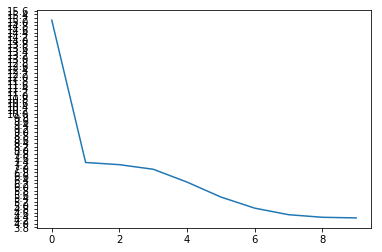

In [100]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [104]:
#this code doesn't work now that code is batchified
#maybe just return the first entry in the batch
#or return the result of a batch

def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence, seq_len = MAX_LENGTH)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [105]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')